In [ ]:
!pip install pymysql
!pip install sqlalchemy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import datetime
import pymysql
from sqlalchemy import create_engine
import FinanceDataReader as fdr
from tqdm import tqdm

In [ ]:
code_data = pd.read_csv('./raw_data.csv', index_col = 0)

code_date['상장일'] dtype을 object → datetime 변경

In [ ]:
code_data['상장일'] = pd.to_datetime(code_data['상장일'])
code_data['종목코드'] = code_data['종목코드'].apply(lambda x: str(x).zfill(6))

# 과제 1

데이터를 dataframe에서 list로 변환

In [ ]:
lst_stock = code_data.values.tolist()

dictionary 사용

In [ ]:
dic_code2company = {}
for row in lst_stock:
    company, code, date = row[0], row[1], row[4]
    if date <= datetime.datetime(2018, 1, 2):
        dic_code2company[code] = company

In [ ]:
OF = open('assignment1_sql.txt', 'w', encoding = 'utf-8')
for code in dic_code2company.keys():
    data = '{}\t{}\n'.format(code, dic_code2company[code])
    OF.write(data)
OF.close()

# 과제 2

In [ ]:
db_dsml = pymysql.connect(
    host = 'localhost', 
    port = 3306, 
    user = 'stock_user', 
    passwd = 'bigdata', 
    db = 'stock', 
    charset = 'utf8'
)

cursor = db_dsml.cursor()

In [ ]:
dic_code2date = {}

OF = open('assignment2_sql.txt', 'w', encoding = 'utf-8')
for code in tqdm(dic_code2company.keys()):
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2018-01-01' AND '2021-12-31'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)
    lst_stock = stock.values.tolist()
    
    for row in lst_stock:
        if row[4] * row[5] >= 10000000000:
            data = '{}\t{}\n'.format(code, row[0].strftime('%Y%m%d'))
            OF.write(data)
            if code not in dic_code2date.keys():
                dic_code2date[code] = []
                dic_code2date[code].append(row[0])
            else:
                dic_code2date[code].append(row[0])
OF.close()

100%|█████████████████████████████████████████████████████████████████████| 1999/1999 [00:40<00:00, 48.96it/s]


# 과제 3 학습데이터셋

In [ ]:
OF = open('assignment3_sql.txt', 'w', encoding = 'utf-8')
for code in tqdm(dic_code2date.keys()):
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2018-01-01' AND '2020-12-31'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)
    lst_stock = stock.values.tolist()
    
    for i, row_lst_stock in enumerate(lst_stock):
        # 예외 처리
        if (i < 9) or (i >= len(lst_stock)-1):
            continue  
        date = row_lst_stock[0]
        if date not in dic_code2date[code]:
            continue
        
        # 11days data
        sub_stock = lst_stock[i-9:i+1]
        next_date = lst_stock[i+1][0]
        lst_data = []
        for row_sub_stock in sub_stock:
            open, high, low, close, volume = row_sub_stock[1:6]
            trading_value = close * volume
            lst_data += [open, high, low, close, trading_value]
            del open
        data = ','.join(map(str, lst_data))
        
        # label
        label = int(lst_stock[i+1][-1] >= 0.02)
        
        result = '{}\t{}\t{}\t{}\t{}\n'.format(code, date.strftime("%Y%m%d"),next_date.strftime("%Y%m%d"), data, label)
        OF.write(result)
OF.close()

100%|█████████████████████████████████████████████████████████████████████| 1878/1878 [00:36<00:00, 51.71it/s]


# 과제 3-2 검증데이터셋

In [ ]:
OF = open('assignment3-2_sql.txt', 'w', encoding = 'utf-8')
for code in tqdm(dic_code2date.keys()):
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2021-01-01' AND '2021-06-30'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)
    lst_stock = stock.values.tolist()
    
    for i, row_lst_stock in enumerate(lst_stock):
        # 예외 처리
        if (i < 9) or (i >= len(lst_stock)-1):
            continue  
        date = row_lst_stock[0]
        if date not in dic_code2date[code]:
            continue
        
        # 11 days data
        sub_stock = lst_stock[i-9:i+1]
        next_date = lst_stock[i+1][0]
        lst_data = []
        for row_sub_stock in sub_stock:
            open, high, low, close, volume = row_sub_stock[1:6]
            trading_value = close * volume
            lst_data += [open, high, low, close, trading_value]
            del open
        data = ','.join(map(str, lst_data))
        
        # label
        label = int(lst_stock[i+1][-1] >= 0.02)
        
        result = '{}\t{}\t{}\t{}\t{}\n'.format(code, date.strftime("%Y%m%d"),next_date.strftime("%Y%m%d"), data, label)
        OF.write(result)
OF.close()

100%|████████████████████████████████████████████████████████████████████| 1878/1878 [00:07<00:00, 238.19it/s]


# 과제3-3 private 시험데이터셋

In [ ]:
OF = open('assignment3-3_sql.txt', 'w', encoding = 'utf-8')
for code in tqdm(dic_code2date.keys()):
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date
                BETWEEN '2021-07-01' AND '2021-12-31'
                '''.format(code)
    stock = pd.read_sql(sql = sql_query, con = db_dsml)
    lst_stock = stock.values.tolist()
    for i, row_lst_stock in enumerate(lst_stock):
        # 예외 처리
        if (i < 9) or (i >= len(lst_stock)-1):
            continue  
        date = row_lst_stock[0]
        if date not in dic_code2date[code]:
            continue
        
        # 11 days data
        sub_stock = lst_stock[i-9:i+1]
        next_date = lst_stock[i+1][0]
        lst_data = []
        for row_sub_stock in sub_stock:
            open, high, low, close, volume = row_sub_stock[1:6]
            trading_value = close * volume
            lst_data += [open, high, low, close, trading_value]
            del open
        data = ','.join(map(str, lst_data))
        
        # label
        label = int(lst_stock[i+1][-1] >= 0.02)
        
        result = '{}\t{}\t{}\t{}\t{}\n'.format(code, date.strftime("%Y%m%d"),next_date.strftime("%Y%m%d"), data, label)
        OF.write(result)
OF.close()

100%|████████████████████████████████████████████████████████████████████| 1878/1878 [00:09<00:00, 208.32it/s]


In [ ]:
import pickle
from sklearn import svm

import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# 과제 4 학습데이터셋

In [ ]:
IF=open("assignment3_sql.txt",'r')

lst_code_date = []
trainX = []
trainY = []

for line in tqdm(IF):
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))

trainX=np.array(trainX)
trainY=np.array(trainY)

clf = XGBClassifier(n_estimators=300, nthread=1)
clf.fit(trainX, trainY)

with open('model_xgb.pickle', 'wb') as f:
    pickle.dump(clf, f)

155946it [00:01, 105933.09it/s]
/package/anaconda3.8/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:11:13] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


# 과제 4-2 검증데이터셋

In [ ]:
import numpy as np
import sklearn.metrics as metrics
import pickle
from sklearn.linear_model import LogisticRegression

IF=open("assignment3-2_sql.txt",'r')
lst_code_date=[]
testX=[]
testY=[]

for line in IF:
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date,next_date])
    testX.append(list(map(int, x.split(","))))
    testY.append(int(y))
testX=np.array(testX)
testY=np.array(testY)

with open('model_xgb.pickle', 'rb') as f:
    clf = pickle.load(f)
    
predY = clf.predict_proba(testX) # predict_proba 함수는 예측한 값을 확률 값으로 출력
predY2 = clf.predict(testX)  # predict 함수는 예측한 값을 이진 값(1 또는 0)으로 출력


In [ ]:
print(predY)

[[0.5359827  0.46401727]
 [0.76500416 0.23499581]
 [0.985542   0.01445801]
 ...
 [0.8210789  0.17892109]
 [0.81774926 0.18225077]
 [0.842813   0.15718696]]


In [ ]:
lst_result=[]
for (code, date, next_date),y in zip(lst_code_date, predY):
    if y[1] >= 0.4:
        lst_result.append([code, date, "buy", "r90"]) 
        lst_result.append([code, next_date, "sell", "all"])  
        
lst_result.sort(key=lambda x:x[1])

OF=open('trading2022firsthalf.txt','w')
for row in lst_result:
    OF.write('\t'.join(map(str,row))+'\n')
OF.close()

# 과제 5 검증데이터셋 수익률

In [ ]:
start_money = 10000000 # 초기 현금 1천만원
money = start_money
dic_code2num ={}  # 보유 종목


IF=open("trading2022firsthalf.txt",'r')
for i, line in tqdm(enumerate(IF)): #주문 일지를 한 줄 읽어 옴
    code, date, request, amount = line.strip().split("\t")
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date = {}
                '''.format(code, date)
    lst_stock = pd.read_sql(sql = sql_query, con = db_dsml).values.tolist()
    for row in lst_stock:
#        if date in row[0].strftime('%Y%m%d'):
        close = row[4]
    
    if request == 'buy': # buy인 경우
        if amount.startswith('r'):
            request_money = money * float(amount.lstrip("r")) / 100
        elif amount == 'all':
            request_money = money
        elif amount.isdigit():
            request_money = int(amount)
        # elif amount == ~~~~~    ##### 기타 필요한 매수 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')
        request_money = min(request_money, money)
        buy_num = int(request_money / close)
        money -= buy_num * close  # 현재 금액(money)을 실제 매수액을 뺀 만큼 업데이트
        if code not in dic_code2num:
            dic_code2num[code] = 0
        dic_code2num[code] += buy_num # 보유 종목 데이터에 구매 종목(code)를 매수 개수 만큼 증가
    if request == 'sell': # sell인 경우
        if amount == 'all':
            sell_num = dic_code2num[code]
        # elif amount == ~~~~~    ##### 기타 필요한 매도 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')            
        money += sell_num * close
        dic_code2num[code] -= sell_num
        if dic_code2num[code] == 0:
            del dic_code2num[code]
IF.close()            
            
if dic_code2num != {}: # 매매가 종료되었는데 보유 종목이 있으면
    raise Exception('Not empty stock') 

print("Final earning rate : {} %".format(str((money-start_money) / start_money * 100)))            

4078it [00:04, 822.76it/s]

Final earning rate : 122.95991 %


# private학습

In [ ]:
IF=open("assignment3_sql.txt",'r')

lst_code_date = []
trainX = []
trainY = []

for line in tqdm(IF):
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))

trainX=np.array(trainX)
trainY=np.array(trainY)

clf = XGBClassifier(n_estimators=300, nthread=1)
clf.fit(trainX, trainY)

with open('model_xgb.pickle', 'wb') as f:
    pickle.dump(clf, f)

155946it [00:01, 80434.92it/s] 


[14:25:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
IF=open("assignment3-3_sql.txt",'r')
lst_code_date=[]
private_testX=[]
private_testY=[]

for line in IF:
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    private_testX.append(list(map(int, x.split(","))))
    private_testY.append(int(y))
private_testX=np.array(private_testX)
private_testY=np.array(private_testY)


with open('model_xgb.pickle', 'rb') as f:
    clf = pickle.load(f)

private_predY = clf.predict_proba(private_testX)
private_predY2 = clf.predict(private_testX)  # predict 함수는 예측한 값을 이진 값(1 또는 0)으로 출력
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(testY, predY)
# print(accuracy)

In [ ]:
private_predY

array([[0.8881538 , 0.1118462 ],
       [0.8461855 , 0.15381448],
       [0.84179854, 0.15820143],
       ...,
       [0.76006484, 0.23993513],
       [0.8172713 , 0.18272871],
       [0.5737015 , 0.4262985 ]], dtype=float32)

In [ ]:
lst_result=[]
for (code, date, next_date),y in zip(lst_code_date, private_predY):
    if y[1] >= 0.3:
        lst_result.append([code, date, "buy", "r80"]) 
        lst_result.append([code, next_date, "sell", "all"])  
        
lst_result.sort(key=lambda x:x[1])

OF=open('trading2022secondhalf.txt','w')
for row in lst_result:
    OF.write('\t'.join(map(str,row))+'\n')
OF.close()

In [ ]:
start_money = 10000000 # 초기 현금 1천만원
money = start_money
dic_code2num ={}  # 보유 종목


IF=open("trading2022secondhalf.txt",'r')
for i, line in tqdm(enumerate(IF)): #주문 일지를 한 줄 읽어 옴
    code, date, request, amount = line.strip().split("\t")
    sql_query = '''
                SELECT *
                FROM stock_{}
                WHERE Date = {}
                '''.format(code, date)
    lst_stock = pd.read_sql(sql = sql_query, con = db_dsml).values.tolist()
    for row in lst_stock:
#        if date in row[0].strftime('%Y%m%d'):
        close = row[4]
    
    if request == 'buy': # buy인 경우
        if amount.startswith('r'):
            request_money = money * float(amount.lstrip("r")) / 100
        elif amount == 'all':
            request_money = money
        elif amount.isdigit():
            request_money = int(amount)
        # elif amount == ~~~~~    ##### 기타 필요한 매수 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')
        request_money = min(request_money, money)
        buy_num = int(request_money / close)
        money -= buy_num * close  # 현재 금액(money)을 실제 매수액을 뺀 만큼 업데이트
        if code not in dic_code2num:
            dic_code2num[code] = 0
        dic_code2num[code] += buy_num # 보유 종목 데이터에 구매 종목(code)를 매수 개수 만큼 증가
    if request == 'sell': # sell인 경우
        if amount == 'all':
            sell_num = dic_code2num[code]
        # elif amount == ~~~~~    ##### 기타 필요한 매도 요청 옵션이 있을 시 작성
        else:
            raise Exception('Not permitted option')            
        money += sell_num * close
        dic_code2num[code] -= sell_num
        if dic_code2num[code] == 0:
            del dic_code2num[code]
IF.close()            
            
if dic_code2num != {}: # 매매가 종료되었는데 보유 종목이 있으면
    raise Exception('Not empty stock') 

print("Final earning rate : {} %".format(str((money-start_money) / start_money * 100))) 

10048it [00:14, 674.44it/s]

Final earning rate : 29.20986 %


# 검증데이터셋 정확도

In [ ]:
IF=open("assignment3_sql.txt",'r')

lst_code_date = []
trainX = []
trainY = []

for line in IF:
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))

trainX=np.array(trainX)
trainY=np.array(trainY)

clf = XGBClassifier(n_estimators=300, nthread=1)
clf.fit(trainX, trainY)

with open('model_xgb.pickle', 'wb') as f:
    pickle.dump(clf, f)

IF=open("assignment3-2_sql.txt",'r')
lst_code_date=[]
testX=[]
testY=[]

for line in IF:
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date,next_date])
    testX.append(list(map(int, x.split(","))))
    testY.append(int(y))
testX=np.array(testX)
testY=np.array(testY)


with open('model_xgb.pickle', 'rb') as f:
    clf = pickle.load(f)
    
predY = clf.predict(testX)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(testY, predY)

print(accuracy)

[01:18:53] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7775924381428969


# private 시험데이터셋 정확도

In [ ]:
IF=open("assignment3_sql.txt",'r')

lst_code_date = []
trainX = []
trainY = []

for line in tqdm(IF):
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    trainX.append(list(map(int, x.split(","))))
    trainY.append(int(y))

trainX=np.array(trainX)
trainY=np.array(trainY)

clf = XGBClassifier(n_estimators=300, nthread=1)
clf.fit(trainX, trainY)

with open('model_xgb.pickle', 'wb') as f:
    pickle.dump(clf, f)
    
IF=open("assignment3-3_sql.txt",'r')
lst_code_date=[]
private_testX=[]
private_testY=[]

for line in IF:
    code, date, next_date, x, y = line.strip().split("\t")
    lst_code_date.append([code, date, next_date])
    private_testX.append(list(map(int, x.split(","))))
    private_testY.append(int(y))
private_testX=np.array(private_testX)
private_testY=np.array(private_testY)


with open('model_xgb.pickle', 'rb') as f:
    clf = pickle.load(f)

private_predY = clf.predict(private_testX)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(private_testY,private_predY)
print(accuracy)

155946it [00:01, 82732.65it/s] 


[14:28:48] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.7925925925925926


# 다양한 모델

In [ ]:
from sklearn.metrics import accuracy_score
name=['Logistic regression','Decision tree','Support vector machine','Gaussian naive bayes','K nearest neighbor',
     'Random forest', 'Gradient boosing','Neural network','XGBClassifier']
result =[]
# 1. Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Logistic Regression:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 2. Decision tree
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Decision tree:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 3. Support vector machine
from sklearn.svm import SVC
model = SVC()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Support vector machine:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 4. Gaussian naive bayes
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Gaussian naive bayes:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 5. K nearest neighbor
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("K nearest neighbor:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 6. Random forest
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Random forest:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 7. Gradient boosing
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Gradient boosing:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

# 8. Neural network
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(max_iter=1000)
model.fit(trainX, trainY)
y_pred_train = model.predict(trainX)
y_pred_test = model.predict(testX)
result.append( accuracy_score(trainY, y_pred_train))

print("Neural network:", accuracy_score(trainY, y_pred_train), accuracy_score(testY, y_pred_test))

result.append(0.648158640226629)

Logistic Regression: 0.7582152974504249 0.7730123406837953
Decision tree: 1.0 0.6332186931013555
Support vector machine: 0.7591359773371105 0.7730123406837953
Gaussian naive bayes: 0.35637393767705383 0.33724458830669635
K nearest neighbor: 0.7864022662889518 0.7210196237102974
Random forest: 1.0 0.7689662148492818
Gradient boosing: 0.7623937677053825 0.7713938903499898
Neural network: 0.7077903682719546 0.7169734978757839


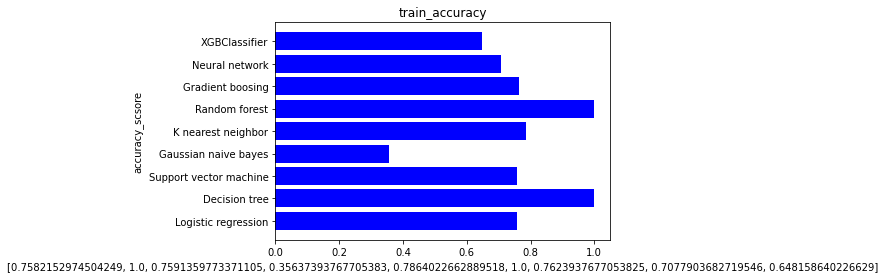

In [ ]:
from matplotlib import pyplot as plt #matplotlib.pyplot 불러오기

plt.barh(name, result, color = "blue") #막대그래프 그리기
plt.ylabel("accuracy_scsore") #y축 라벨 설정
plt.xlabel(result) #x축 라벨 설정
plt.title('train_accuracy') #그래프 제목 설정
plt.show() #막대그래
